# Notebook for measuring the bandwidth

Jan Wüthrich, Nina Horat & Laura Endres

In [1]:
#Libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import numpy as np

In [2]:
#Name Lists
backend_list = ["gt4py",
                "cupy",
                "numba_cuda"
]

## Timing
### Execute memory transfer for evaluation

In [3]:
#Parameter 
field_size_list = [8,16,32,64,128,256,512]
df_name = "bandwidth_final" #Name of evaluation dataframe
num_iter = 20

#timing
for size in field_size_list:
    print(size,':')
    for y in backend_list:
        bashCommand=f"/users/course17/HPC4WC_venv/bin/python main_bandwidth.py --nx {size} --ny {size} --nz {size} --backend {y} --num_iter {num_iter} --df_name {df_name}"
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        print('                 ',y,' calculated.')
        output, error = process.communicate()
        print(output.decode("utf-8"))

8 :
                  gt4py  calculated.
Total transfertime from CPU to GPU: 0.0005004405975341797 s. In 20 iteration(s) the average lapsed time for one transfer is 2.5022029876708985e-05 +/- 2.3692077798195832e-06 s
Total transfertime from GPU to CPU: 0.00045299530029296875 s. In 20 iteration(s) the average lapsed time for one transfer is 2.2649765014648438e-05 +/- 4.144644879810112e-06 s
data transferred = 3.814697265625e-06 GB
peak memory bandwidth = 32 GB/s
memory bandwidth =  0.15245 GB/s
memory bandwidth =  0.16842 GB/s
peak =  0.00476
peak =  0.00526
New dataframe bandwidth_final_cpu_to_gpu generated.
New dataframe bandwidth_final_gpu_to_cpu generated.

                  cupy  calculated.
Total transfertime from CPU to GPU: 0.0004487037658691406 s. In 20 iteration(s) the average lapsed time for one transfer is 2.243518829345703e-05 +/- 1.2440538899024164e-05 s
Total transfertime from GPU to CPU: 0.00043129920959472656 s. In 20 iteration(s) the average lapsed time for one transfe

### Read out the dataframe and plot results
The program saves the evaluation data into a pandas dataframe (Name is defined with the option --df_name). Subsequently the df can be accessed for further processing within a jupyter notebook.

## Data analysis:

In [3]:
df_cpu_to_gpu= pd.read_pickle("eval/{}_result.pkl".format("bandwidth_final_cpu_to_gpu"))

df_gpu_to_cpu= pd.read_pickle("eval/{}_result.pkl".format("bandwidth_final_gpu_to_cpu"))

In [6]:
df_gpu_to_cpu.tail()

,backend,nx,ny,nz,num_iter,time_total,time_avg,time_stdev,number_of_gbytes,memory_bandwidth_in_gbs,memory_bandwidth_stdev,peak_bandwidth_in_gbs,fraction_of_peak_bandwidth,fraction_of_peak_bandwidth_stdev
16,cupy,256,256,256,20,1.297719,0.064886,0.000386,0.125,1.926457,323.629874,32,0.060202,10.113434
17,numba_cuda,256,256,256,20,1.292240,0.064612,0.000757,0.125,1.934625,165.132451,32,0.060457,5.160389
18,gt4py,512,512,512,20,1.627929,0.081396,0.000051,1.000,12.285545,19443.710969,32,0.383923,607.615968
19,cupy,512,512,512,20,10.312110,0.515606,0.006390,1.000,1.939467,156.498341,32,0.060608,4.890573
20,numba_cuda,512,512,512,20,10.152500,0.507625,0.005956,1.000,1.969958,167.886739,32,0.061561,5.246461


### CPU to GPU:

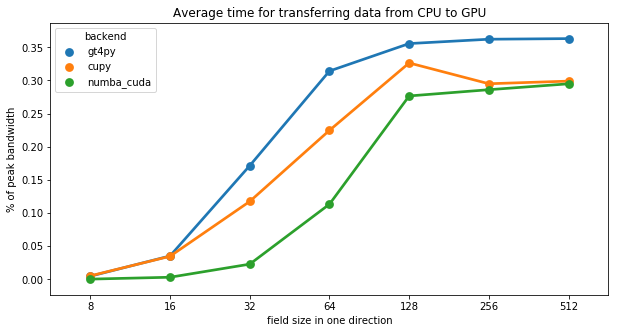

In [4]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y="fraction_of_peak_bandwidth", 
                  hue="backend",
                  data=df_cpu_to_gpu, cd=False
                 )
chart.set(xlabel='field size in one direction', ylabel='% of peak bandwidth')
plt.title('Average time for transferring data from CPU to GPU')
#chart.set_yscale("log")
plt.savefig('bandwidth3_cpu_to_gpu.png',dpi=300)

### GPU to CPU:

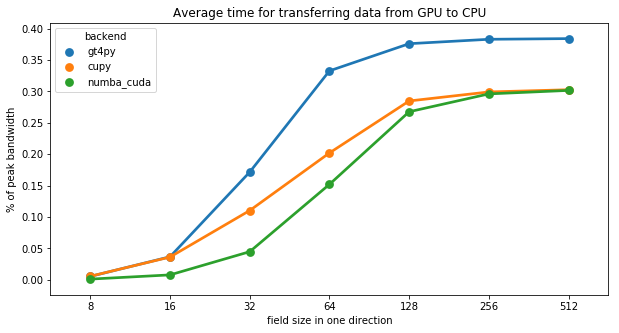

In [5]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y="fraction_of_peak_bandwidth", 
                  hue="backend",
                  data=df_gpu_to_cpu, cd=False
                 )
chart.set(xlabel='field size in one direction', ylabel='% of peak bandwidth')
plt.title('Average time for transferring data from GPU to CPU')
#chart.set_yscale("log")
plt.savefig('bandwidth3_gpu_to_cpu.png',dpi=300)

### transfer in both directions

In [8]:
df_cpu_to_gpu["direction"]= "cpu_to_gpu"
df_gpu_to_cpu["direction"]= "gpu_to_cpu"
df= pd.concat([df_cpu_to_gpu,df_gpu_to_cpu])
df["fraction_of_peak_bandwidth"]=df.fraction_of_peak_bandwidth*100

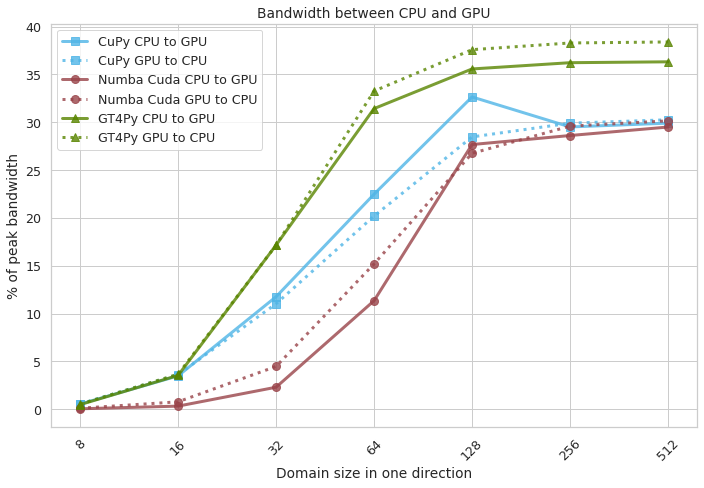

In [13]:
#image style
df_color=pd.DataFrame({'gt4py': "#598500",'cupy': "#4FB5E6", 'numba_cuda': "#994349"},index=[0])
df_marker=pd.DataFrame({'gt4py': "^",'cupy': "s", 'numba_cuda': "o"},index=[0])
df_linestyle = pd.DataFrame({'cpu_to_gpu': '-', 'gpu_to_cpu':':'}, index=[0])
df_label_device = pd.DataFrame({'cpu_to_gpu': ' CPU to GPU', 'gpu_to_cpu':' GPU to CPU'}, index=[0])
df_label_backend = pd.DataFrame({'gt4py': "GT4Py",'cupy': "CuPy", 'numba_cuda': "Numba Cuda"},index=[0])

f = plt.figure(figsize=(10, 7))
#gs = f.add_gridspec(1, 2)

sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2})    
with sns.axes_style("whitegrid"):
    #ax = f.add_subplot(gs[0, 0]) 
    
    for back in ["cupy", "numba_cuda", "gt4py"]:
        for direct in ["cpu_to_gpu", "gpu_to_cpu"]:
            df_sub= df[((df.direction == direct) & (df.backend == back))]
            xs=[0,1,2,3,4,5,6]
            plt.xticks(xs,(8,16,32,64,128,256,512))
            plt.xticks(rotation=45)
            plt.plot(xs, df_sub['fraction_of_peak_bandwidth'], alpha =0.8,color = df_color[back][0], linestyle=df_linestyle[direct][0], 
                     label = df_label_backend[back][0] + df_label_device[direct][0], marker =df_marker[back][0], lw = 3, ms=8)
    plt.xlabel("Domain size in one direction")
    plt.ylabel("% of peak bandwidth")
    plt.title('Bandwidth between CPU and GPU')

    plt.legend()
    plt.tight_layout()

    plt.savefig('bandwidth.png',dpi=300) 

In [72]:
#df_gpu_to_cpu["bandwidth"]=df_gpu_to_cpu.number_of_gbytes/df_gpu_to_cpu.time
#df_gpu_to_cpu["percent_peakbandwidth"]=df_gpu_to_cpu.bandwidth/df_gpu_to_cpu.peak_bandwidth_in_gbs

### Average time for transferring data from CPU to GPU

In [18]:
df_old= pd.read_pickle("eval/{}_result.pkl".format("bandwidth"))

Text(0.5, 1.0, 'Average time for transferring data from CPU to GPU')

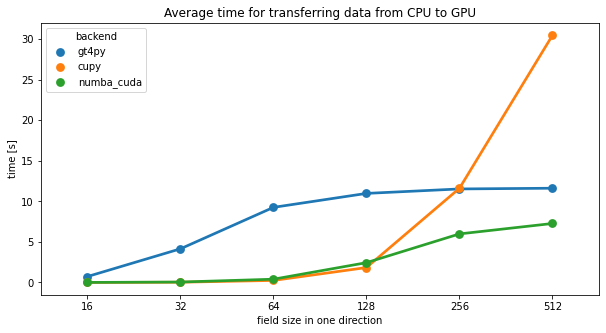

In [21]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_old,ci=False
                 )
chart.set(xlabel='field size in one direction', ylabel='time [s]')
plt.title('Average time for transferring data from CPU to GPU')
#chart.set_yscale("log")

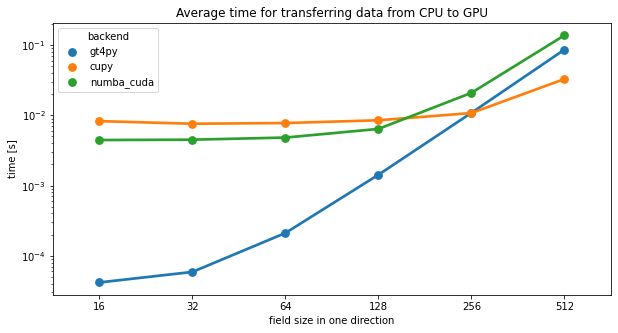

In [22]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y="time_avg", 
                  hue="backend",
                  data=df_old,ci=False
                 )
chart.set(xlabel='field size in one direction', ylabel='time [s]')
plt.title('Average time for transferring data from CPU to GPU')
chart.set_yscale("log")

<ErrorbarContainer object of 3 artists>

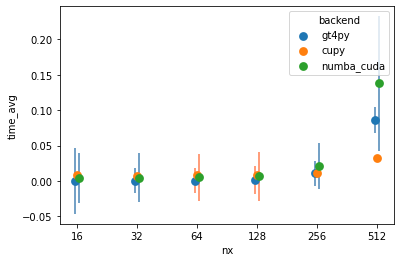

In [23]:
ax = sns.pointplot('nx', 'time_avg', hue='backend',
    data=df_old, dodge=True, join=False, ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
errors = df_old.sort_values(['backend'],ascending=False).time_stdev
colors = ['steelblue']*2 + ['coral']*2
ax.errorbar(x_coords, y_coords, yerr=errors,
    ecolor=colors, fmt=' ', zorder=-1)

[Text(0, 0, '2^15'),
 Text(0, 0, '2^18'),
 Text(0, 0, '2^21'),
 Text(0, 0, '2^24'),
 Text(0, 0, '2^27'),
 Text(0, 0, '2^30')]

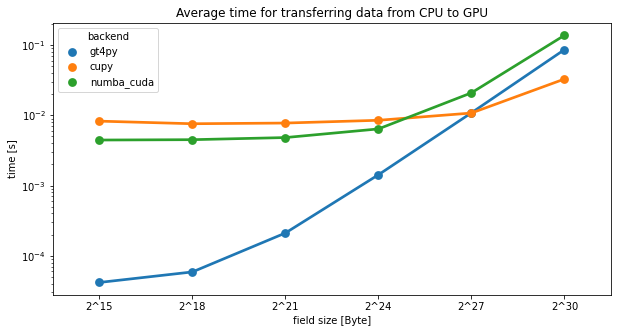

In [27]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="time_avg", 
                  hue="backend",
                  data=df_old,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='time [s]')
plt.title('Average time for transferring data from CPU to GPU')
chart.set_yscale("log")

texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append("2^" + str(int(np.log2(float(i)*1024**3))))
chart.set_xticklabels(ticks)

### Bandwidth for data transfer from CPU to GPU

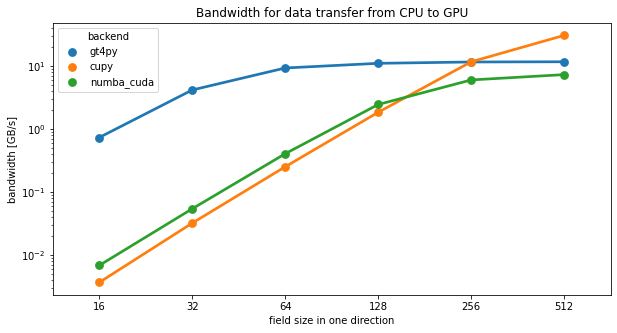

In [28]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_old,ci=False
                 )
chart.set(xlabel='field size in one direction', ylabel='bandwidth [GB/s]')
plt.title('Bandwidth for data transfer from CPU to GPU')
chart.set_yscale("log")

[Text(0, 0, '2^15'),
 Text(0, 0, '2^18'),
 Text(0, 0, '2^21'),
 Text(0, 0, '2^24'),
 Text(0, 0, '2^27'),
 Text(0, 0, '2^30')]

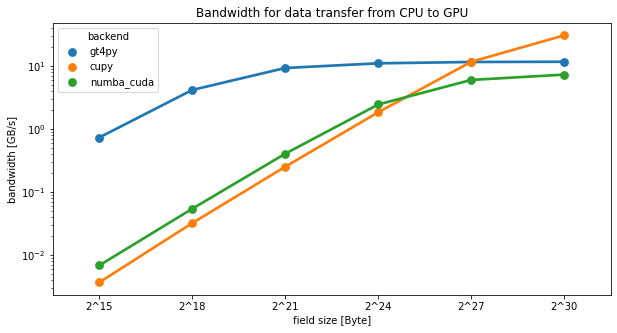

In [29]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_old,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='bandwidth [GB/s]')
plt.title('Bandwidth for data transfer from CPU to GPU')
chart.set_yscale("log")
#chart.set_xscale("log")

texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append("2^" + str(int(np.log2(float(i)*1024**3))))
chart.set_xticklabels(ticks)

### in percent of peak bandwidth

Text(0.5, 1.0, 'Bandwidth in percent of peak bandwidth')

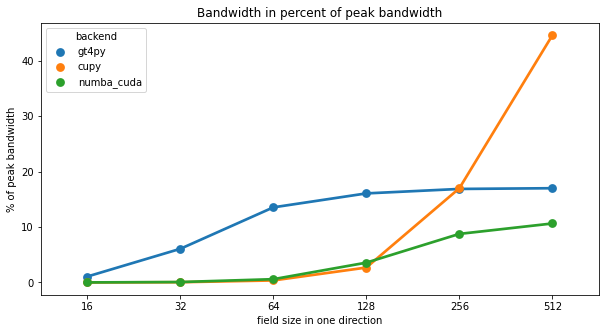

In [32]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y=df_old.fraction_of_peak_bandwidth*100, 
                  hue="backend",
                  data=df_old,ci=False
                 )
chart.set(xlabel='field size in one direction', ylabel='% of peak bandwidth')
plt.title('Bandwidth in percent of peak bandwidth')
#chart.set_yscale("log")


[Text(0, 0, '2^15'),
 Text(0, 0, '2^18'),
 Text(0, 0, '2^21'),
 Text(0, 0, '2^24'),
 Text(0, 0, '2^27'),
 Text(0, 0, '2^30')]

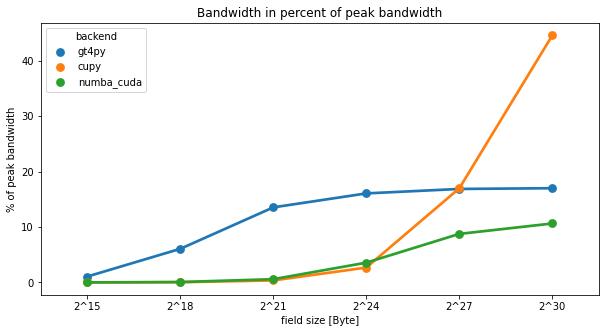

In [33]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y=df_old.fraction_of_peak_bandwidth*100, 
                  hue="backend",
                  data=df_old,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='% of peak bandwidth')
plt.title('Bandwidth in percent of peak bandwidth')
#chart.set_yscale("log")

texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append("2^" + str(int(np.log2(float(i)*1024**3))))
chart.set_xticklabels(ticks)

### Detailed analysis for data between 1 and 8 GB: 

In [27]:
#Parameter 
field_size_nx = 512
field_size_ny = [512,1024]
field_size_nz = [512, 1024]

df_name = "bandwidth_detailed" #Name of evaluation dataframe
num_iter = 20

#timing
for size_ny in field_size_ny:
    for size_nz in field_size_nz:
        if size_nz >=size_ny: 
            print(field_size_nx,'x', size_ny, 'x', size_nz, ':')
            for y in backend_list:
                bashCommand=f" python3 main_bandwidth.py --nx {field_size_nx} --ny {size_ny} --nz {size_nz} --backend {y} --num_iter {num_iter} --df_name {df_name}"
                process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
                print('                 ',y,' calculated.')
                output, error = process.communicate()
                #print(output.decode("utf-8"))

512 x 512 x 512 :
                  gt4py  calculated.
Total worktime: 1.7221884727478027 s. In 20 iteration(s) the average lapsed time for one run is 0.08610942363739013 +/- 1.1089386093435624e-05 s
data transferred = 1.0 GB
memory bandwidth = 11.61313 GB/s
peak memory bandwidth = 68.3 GB/s
%peak =  0.17003%
New dataframe bandwidth_detailed generated.

                  cupy  calculated.
Total worktime: 0.6409006118774414 s. In 20 iteration(s) the average lapsed time for one run is 0.03204503059387207 +/- 0.09378512648059639 s
data transferred = 1.0 GB
memory bandwidth = 31.20609 GB/s
peak memory bandwidth = 68.3 GB/s
%peak =  0.45690%

                  numba_cuda  calculated.
Total worktime: 2.749093532562256 s. In 20 iteration(s) the average lapsed time for one run is 0.13745467662811278 +/- 0.046814044689177894 s
data transferred = 1.0 GB
memory bandwidth =  7.27513 GB/s
peak memory bandwidth = 68.3 GB/s
%peak =  0.10652%

512 x 512 x 1024 :
                  gt4py  calculated.
To

In [28]:
df_data= pd.read_pickle("eval/{}_result.pkl".format("bandwidth_detailed"))

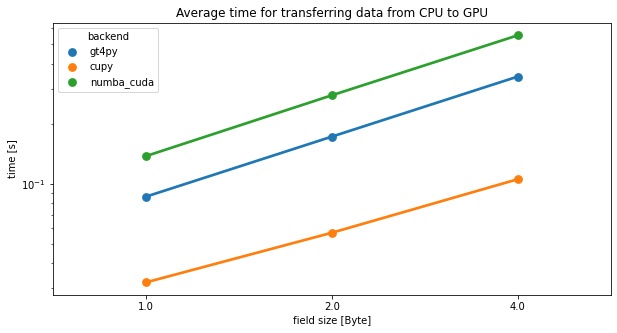

In [29]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="time_avg", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='time [s]')
plt.title('Average time for transferring data from CPU to GPU')
chart.set_yscale("log")

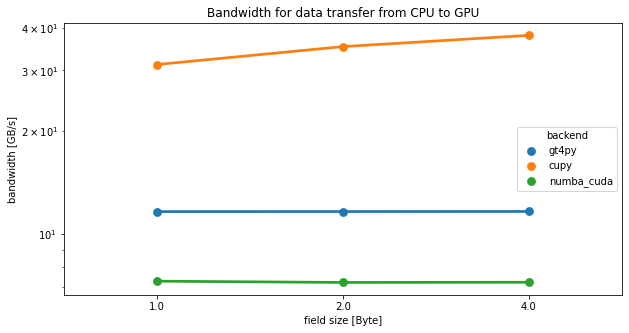

In [30]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='bandwidth [GB/s]')
plt.title('Bandwidth for data transfer from CPU to GPU')
chart.set_yscale("log")
#chart.set_xscale("log")

Text(0.5, 1.0, 'Bandwidth in percent of peak bandwidth')

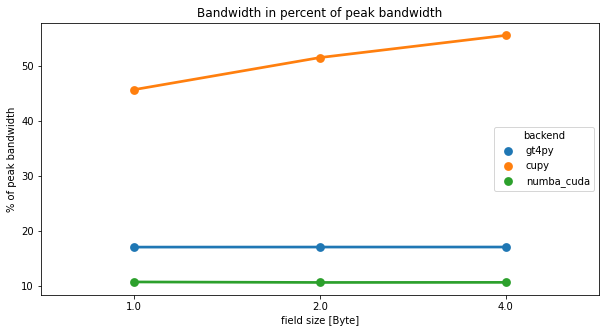

In [31]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y=df_data.fraction_of_peak_bandwidth*100, 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='% of peak bandwidth')
plt.title('Bandwidth in percent of peak bandwidth')
#chart.set_yscale("log")


### diverses:

In [67]:
texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append('{:.2e}'.format(float(i)))
print(ticks)

['3.05e-05', '2.44e-04', '1.95e-03', '1.56e-02', '1.25e-01', '1.00e+00']
['3.05e-05', '2.44e-04', '1.95e-03', '1.56e-02', '1.25e-01', '1.00e+00']


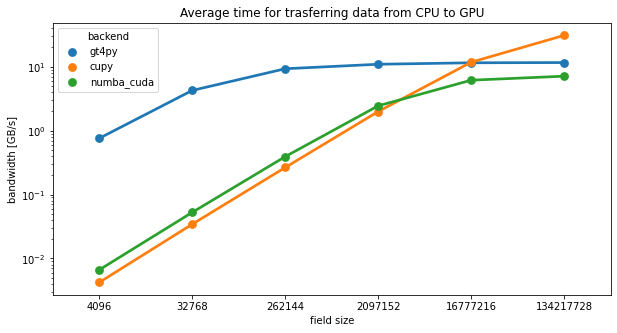

In [97]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x=df_data.nx*df_data.ny*df_data.nz, y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size', ylabel='bandwidth [GB/s]')
plt.title('Average time for trasferring data from CPU to GPU')
chart.set_yscale("log")
#chart.set_xscale("linear")